# KNN Classifier (Mask, No Mask, Incorrect Mask)

## Imports

In [1]:
# import packages
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA # Dimensionality Reduction

import seaborn as sns # for confusion matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # to plot inage, graph

import pickle
import time # for computation time assessment
%matplotlib inline

## Prepare Dataset

### Pickle Dataset

In [2]:
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle", "rb")
y = pickle.load(pickle_in)

pickle_in = open("data.pickle", "rb")
data = pickle.load(pickle_in) # Data Matrix will serve as X

### Dataset Classification Distribution

In [3]:
# RECALL
# CLASS 0: NO MASK
# CLASS 1: INCORRECT WEAR OF MASK
# CLASS 2: CORRECT WEAR OF MASK
# See Data Preprocessing for more information

print('# of Samples:', len(y))
print('# of Without A Mask:', (y == 0).sum())
print('# of Incorrectly Worn Mask:', (y == 1).sum())
print('# of With A Mask:', (y == 2).sum())

# of Samples: 17687
# of Without A Mask: 5909
# of Incorrectly Worn Mask: 5895
# of With A Mask: 5883


### Convert Numpy to Dataframe

In [4]:
# Get Column Names
cols = []
for i in range(0, len(data[0])):
    cols.append("P" + str(i))

# Convert to Dataframe
numpy_data = data
X = pd.DataFrame(data=numpy_data, columns=[cols])
print(X.head())

y = pd.DataFrame(data=y, columns=["Mask_Target"])
print(y.head())

    P0   P1   P2   P3   P4   P5   P6   P7   P8   P9  ... P4086 P4087 P4088  \
0   20   21   19   22   29   31   37   51   54   37  ...   132   131   106   
1  127  127  125  126   87   69   34   30   33   37  ...   141   156   156   
2   48   43   37   34   34   40   49   83  100  106  ...    79    58    41   
3  184   91   63   25   14   17   15   35   44   41  ...    84    86    53   
4  111  125  126   97  109  140  168  185  166   91  ...   138    61    27   

  P4089 P4090 P4091 P4092 P4093 P4094 P4095  
0   158   125    43    24    21    21    34  
1   149   150   149   145   125   115   103  
2    21    14    19    22    23    20    21  
3    17    13    13    14    11    13    15  
4    35    30    38    34    45    54    48  

[5 rows x 4096 columns]
   Mask_Target
0            0
1            0
2            0
3            0
4            0


### Data Shape

In [5]:
# Shape
print('\nImage Data Shape:', X.shape)
print('Image Data Shape Features:', data.shape)
print('Image Data Shape Target:', y.shape)


Image Data Shape: (17687, 4096)
Image Data Shape Features: (17687, 4096)
Image Data Shape Target: (17687, 1)


### Normalize the Data

In [6]:
# Normalize the pixel values
X = X / 255.0

### Split Train + Test, random_state

In [7]:
# Split our data into testing and training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# Print the length and width of our testing data.
print('Length of our Training data: ', len(X_train), '\nLength of our Testing data: ', len(X_test))

Length of our Training data:  14149 
Length of our Testing data:  3538


## KNN No Hyperparameter Tuning
Build and train KNN model with default parameters

In [8]:
# Initialize KNN model
knn = KNeighborsClassifier()

# Use training data to fit KNN model
knn.fit(X_train, y_train.values.ravel())

KNeighborsClassifier()

In [9]:
%%time
# make prediction on entire test data
predictions_set1 = knn.predict(X_test)

CPU times: user 5min 4s, sys: 446 ms, total: 5min 4s
Wall time: 5min 5s


In [10]:
# Save Predictions in a pickle
pickle_out = open("predictions_set1.pickle", "wb")
pickle.dump(predictions_set1, pickle_out)
pickle_out.close()

## Performance Metrics for No Hyperparameter Tuning

#### Accuracy

In [11]:
# 75-82% accuracy depending on the divide
print('KNN Accuracy: %.3f' % accuracy_score(y_test, predictions_set1))

KNN Accuracy: 0.758


#### Confusion Matrix

Text(0.5, 1.0, 'Accuracy Score: 0.7577727529677784')

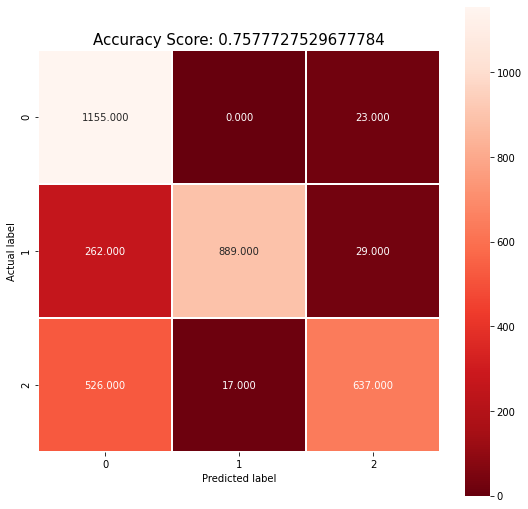

In [12]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test, predictions_set1)

plt.figure(figsize=(9,9))
# Heatmap visualization of accuracy
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Reds_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, predictions_set1))
plt.title(all_sample_title,size=15)

### Precision, Recall, F1 Score & Classification Report, No Hyperparameter Tuning

In [13]:
print('KNN Precision: %.3f' % precision_score(y_test, predictions_set1, average='micro'))
print('KNN Recall: %.3f' % recall_score(y_test, predictions_set1, average='micro'))
print('KNN F1 Score: %.3f' % f1_score(y_test, predictions_set1, average='micro'))
print("\nNo Hyperparameter Tuning Classification Report\n", classification_report(y_test, predictions_set1))

KNN Precision: 0.758
KNN Recall: 0.758
KNN F1 Score: 0.758

No Hyperparameter Tuning Classification Report
               precision    recall  f1-score   support

           0       0.59      0.98      0.74      1178
           1       0.98      0.75      0.85      1180
           2       0.92      0.54      0.68      1180

    accuracy                           0.76      3538
   macro avg       0.83      0.76      0.76      3538
weighted avg       0.83      0.76      0.76      3538



## Dimensionality Reduction

### Principal Component Analysis, Keep 90% of variance

In [35]:
# Dimensionality Reduction with Principal Component Analysis (PCA)
pca = PCA(0.90) # Preserve 90% of the variance

X_transformed = pca.fit_transform(X_train) # Fit the pca transform with X_train
X_test_transformed = pca.transform(X_test) # Apply transform to X_test

# Training set shape after Principal Component Analysis form
print(X_transformed.shape)

# Original Training Set Shape
# Notice we lose 3,943 features using PCA, while preserving 90% variance
print(X_train.shape)

(14149, 153)
(14149, 4096)


In [36]:
# Initialize KNN model for PCA instance
knn_pca = KNeighborsClassifier()

# Use training data to fit KNN model with transformed X_train
knn_pca.fit(X_transformed, y_train.values.ravel())

KNeighborsClassifier()

In [37]:
%%time
# make prediction on entire train data
predictions_set_pca = knn_pca.predict(X_transformed)
print("Accuracy Train PCA:", accuracy_score(y_train, predictions_set_pca))

Accuracy Train PCA: 0.8908050038872005
CPU times: user 34.7 s, sys: 113 ms, total: 34.9 s
Wall time: 35 s


In [38]:
%%time
# make prediction on entire test data
predictions_set_pca = knn_pca.predict(X_test_transformed)
print("Accuracy Train PCA:", accuracy_score(y_test, predictions_set_pca))

Accuracy Train PCA: 0.8352176370830978
CPU times: user 8.6 s, sys: 20.4 ms, total: 8.62 s
Wall time: 8.64 s



 Best Params PCA Classification Report
               precision    recall  f1-score   support

           0       0.70      0.97      0.81      1178
           1       0.97      0.89      0.93      1180
           2       0.94      0.64      0.76      1180

    accuracy                           0.84      3538
   macro avg       0.87      0.84      0.83      3538
weighted avg       0.87      0.84      0.83      3538



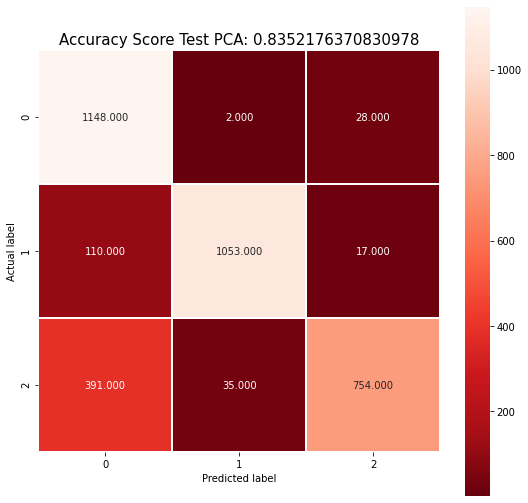

In [39]:
# Calculate Confusion Matrix for PCA
cm = confusion_matrix(y_test, predictions_set_pca)

plt.figure(figsize=(9,9))

# Heatmap visualization of accuracy
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Reds_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Accuracy Score Test PCA: {0}'.format(accuracy_score(y_test, predictions_set_pca))
plt.title(title,size=15)

print("\n Best Params PCA Classification Report\n", classification_report(y_test, predictions_set_pca))

## KNN Hyperparameter Tuning with GridSearchCV

In [14]:
# New KNN instance model
knn = KNeighborsClassifier()

# Dictionary of parameter values we are testing performance for
param_grid = {'n_neighbors': [5, 7, 9, 11], 'p': [2, 4, 6, 8, 10, 20, 50], 'metric': ['euclidean', 'manhattan']}

# Test all parameter combinations in param_grid
knn_gscv = GridSearchCV(knn2, param_grid, scoring='f1_micro', cv=5, verbose=3, n_jobs=-1)

In [15]:
# Fit model to data
knn_gscv.fit(X_train, y_train.values.ravel())

In [16]:
# Get GridSearchCV's top performing parameters and score

# Best Params: n_neighbors=5, distance=manhattan, p=2
best_params_ = knn_gscv.best_params_

# Best Score 82.7%
knn_gscv.best_score_

## KNN Hyperparameter Tuning with RandomizedSearchCV

In [17]:
# Parameter values that should be tested
k_range = list(range(1,21))
metric = ['manhattan'] # Manhattan distance outperformed Euclidean in GridSearch, so we exclude it here
options = ['uniform', 'distance']

# Set parameter grid respectively
param_grid = dict(n_neighbors=k_range, metric=metric, weights=options)

In [34]:
# Notes on RandomizedSearchCV parameters
    # n_iter: Number of random combinations it would try
    # random_state: Reproducibility/ Set seed

# # Initialize new KNN model
# knn_rand = KNeighborsClassifier()

# # Initialize Randomized Search with params
# # Cross Validation is 10
# rand = RandomizedSearchCV(knn_rand, param_grid, cv=10, scoring='accuracy', n_iter=10, random_state=5)

# # Fit Randomized Search with the training data
# rand.fit(X_train, y_train.values.ravel())

# OUTPUT
# RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(),
#                    param_distributions={'metric': ['manhattan'],
#                                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
#                                                         9, 10, 11, 12, 13, 14,
#                                                         15, 16, 17, 18, 19,
#                                                         20],
#                                         'weights': ['uniform', 'distance']},
#                    random_state=5, scoring='accuracy')

In [ ]:
rand.best_params_ 
# OUTPUT
# {'weights': 'distance', 'n_neighbors': 2, 'metric': 'manhattan'}

In [ ]:
rand.best_score_ 
# OUTPUT
# 0.8652206356425648

In [ ]:
# Initial Randomized Search CV result
# 0.7488861511088009
# {'weights': 'distance', 'n_neighbors': 10}

## Performance of Best Params

In [19]:
best_params = {'weights': 'distance', 'n_neighbors': 2, 'metric': 'manhattan'}

In [27]:
# create new a knn model with best params
b_knn = KNeighborsClassifier(**best_params)

#fit model to data
b_knn.fit(X_train, y_train.values.ravel())

# make prediction on entire test data
train_pred = b_knn.predict(X_train)

# make prediction on entire test data
y_pred = b_knn.predict(X_test)

print('Accuracy Train: %.3f' % accuracy_score(y_train, train_pred))
print('Accuracy Test: %.3f' % accuracy_score(y_test, y_pred))
print("\nClassification Report\n", classification_report(y_test, y_pred))

Accuracy Train: 1.000
Accuracy Test: 0.864

Classification Report
               precision    recall  f1-score   support

           0       0.75      0.96      0.84      1178
           1       0.99      0.84      0.91      1180
           2       0.91      0.79      0.85      1180

    accuracy                           0.86      3538
   macro avg       0.88      0.86      0.87      3538
weighted avg       0.88      0.86      0.87      3538



Text(0.5, 1.0, 'Accuracy Score Best Params: 0.8640474844544941')

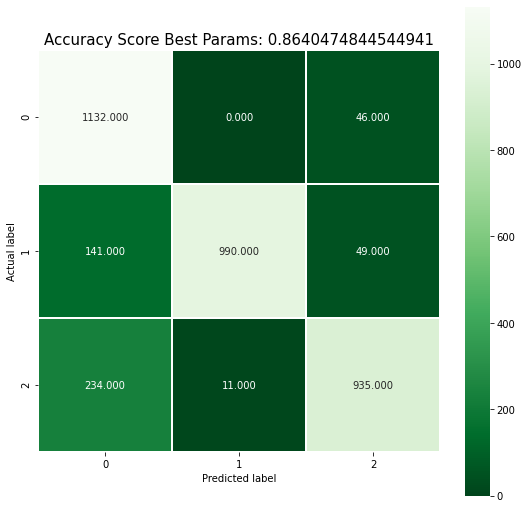

In [28]:
# Calculate Confusion Matrix for Best Param Model
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
# Heatmap visualization of accuracy
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Greens_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Accuracy Score Best Params: {0}'.format(accuracy_score(y_test, y_pred))
plt.title(title,size=15)

## Dimensionality Reduction [Best Params]

> Uses Principal Component Analysis on a KNN model with the Best Params.

### Principal Component Analysis, Keep 90% of variance

In [29]:
# Dimensionality Reduction with Principal Component Analysis (PCA)
pca = PCA(0.90) # Preserve 90% of the variance

X_transformed = pca.fit_transform(X_train) # Fit the pca transform with X_train
X_test_transformed = pca.transform(X_test) # Apply transform to X_test

# Training set shape after Principal Component Analysis form
print(X_transformed.shape)

# Original Training Set Shape
# Notice we lose 3,943 features using PCA, while preserving 90% variance
print(X_train.shape)

(14149, 153)
(14149, 4096)


In [30]:
# Initialize KNN model for PCA instance
knn_pca = KNeighborsClassifier(**best_params)

# Use training data to fit KNN model with transformed X_train
knn_pca.fit(X_transformed, y_train.values.ravel())

KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance')

In [31]:
%%time
# make prediction on entire train data
predictions_set_pca = knn_pca.predict(X_transformed)
print("Accuracy Train Best Params PCA:", accuracy_score(y_train, predictions_set_pca))

Accuracy Train Best Params PCA: 1.0
CPU times: user 51.2 s, sys: 93.5 ms, total: 51.3 s
Wall time: 51.4 s


In [32]:
%%time
# make prediction on entire test data
predictions_set_pca = knn_pca.predict(X_test_transformed)
print("Accuracy Train Best Params PCA:", accuracy_score(y_test, predictions_set_pca))

Accuracy Train Best Params PCA: 0.8174109666478236
CPU times: user 13.3 s, sys: 85.7 ms, total: 13.4 s
Wall time: 13.6 s


### PCA Classification Report


 Best Params PCA Classification Report
               precision    recall  f1-score   support

           0       0.68      0.97      0.80      1178
           1       0.98      0.81      0.89      1180
           2       0.91      0.67      0.77      1180

    accuracy                           0.82      3538
   macro avg       0.86      0.82      0.82      3538
weighted avg       0.86      0.82      0.82      3538



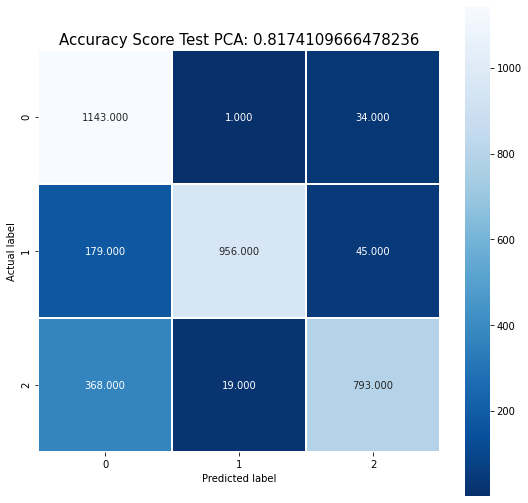

In [33]:
# Calculate Confusion Matrix for 
cm = confusion_matrix(y_test, predictions_set_pca)

plt.figure(figsize=(9,9))

# Heatmap visualization of accuracy
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Accuracy Score Test PCA: {0}'.format(accuracy_score(y_test, predictions_set_pca))
plt.title(title,size=15)

print("\n Best Params PCA Classification Report\n", classification_report(y_test, predictions_set_pca))

## Testing Model Bias 

Two datasets will be examined and used as unseen test data for our model.
- People of Color (POC) dataset
- White Individuals (W) dataset

We will be using the KNN Model with the best parameters discovered above.

In [40]:
# Best Parameters for KNN Model
best_params = {'weights': 'distance', 'n_neighbors': 2, 'metric': 'manhattan'}

In [41]:
# Load POC datasets
pickle_in = open("X_test_POC.pickle", "rb")
poc_X = pickle.load(pickle_in)
pickle_in = open("y_test_POC.pickle", "rb")
poc_y = pickle.load(pickle_in)

# POC target and feature set shape
print("Features, poc_X shape: ", poc_X.shape)
print("Target, poc_y shape: ", poc_y.shape)

# Normalize the pixel values
poc_X = poc_X / 255.0

#===================================================================

# Load W datasets
pickle_in = open("X_test_W.pickle", "rb")
w_X = pickle.load(pickle_in)
pickle_in = open("y_test_W.pickle", "rb")
w_y = pickle.load(pickle_in)

# W target and feature set shape
print("Features, w_X shape: ", w_X.shape)
print("Target, w_y shape: ", w_y.shape)

# Normalize the pixel values
w_X = w_X / 255.0

Features, poc_X shape:  (309, 4096)
Target, poc_y shape:  (309,)
Features, w_X shape:  (309, 4096)
Target, w_y shape:  (309,)


In [42]:
# Re-initialize KNN model with best params and fit it
knn_poc = KNeighborsClassifier(**best_params)
knn_poc.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance')

In [44]:
# make prediction on the entire POC dataset
y_pred_poc = knn_poc.predict(poc_X)

In [47]:
# make prediction on the entire W dataset
y_pred_w = knn_poc.predict(w_X)

Text(0.5, 1.0, 'POC Accuracy Score: 0.5016181229773463')

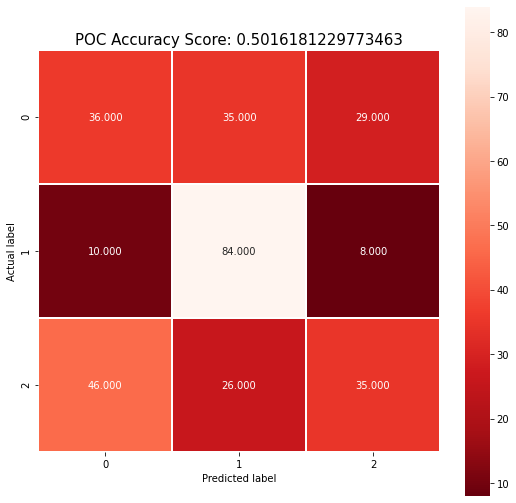

In [52]:
# Calculate Confusion Matrix
cm = confusion_matrix(poc_y, y_pred_poc)

plt.figure(figsize=(9,9))
# Heatmap visualization of accuracy
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Reds_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'POC Accuracy Score: {0}'.format(accuracy_score(poc_y, y_pred_poc))
plt.title(title,size=15)

Text(0.5, 1.0, 'W Accuracy Score: 0.343042071197411')

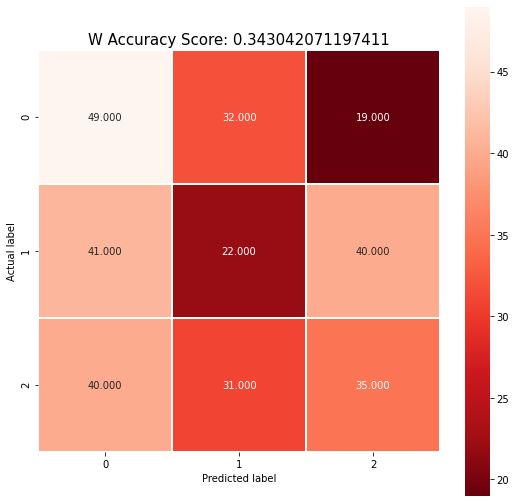

In [53]:
# Calculate Confusion Matrix
cm = confusion_matrix(w_y, y_pred_w)

plt.figure(figsize=(9,9))
# Heatmap visualization of accuracy
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Reds_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'W Accuracy Score: {0}'.format(accuracy_score(w_y, y_pred_w))
plt.title(title,size=15)

In [50]:
print("\nClassification Report Best Params\n", classification_report(y_test, y_pred))
print("\nClassification Report POC Test Dataset\n", classification_report(poc_y, y_pred_poc))


Classification Report Best Params
               precision    recall  f1-score   support

           0       0.75      0.96      0.84      1178
           1       0.99      0.84      0.91      1180
           2       0.91      0.79      0.85      1180

    accuracy                           0.86      3538
   macro avg       0.88      0.86      0.87      3538
weighted avg       0.88      0.86      0.87      3538


Classification Report POC Test Dataset
               precision    recall  f1-score   support

           0       0.39      0.36      0.37       100
           1       0.58      0.82      0.68       102
           2       0.49      0.33      0.39       107

    accuracy                           0.50       309
   macro avg       0.49      0.50      0.48       309
weighted avg       0.49      0.50      0.48       309



## Conclusion

Overall the KNN Model performs fairly good. While it doesn't have the best overall accuracies, it appears to classify `incorrect wear of face mask` and `correct wear of face mask` categories with high precision (~92-98%). Contrastingly, however, the model underperformed for predicting the `no face mask` label (with precision ~59%). This is significant because accurately classifying the `no face mask` label is critical in determining the efficacy of face masks in terms of virus transmission and potential outbreaks. This underperformance for the `no mask` label can occur from a range of causes including a poor split between testing and training data, overfitting parameters, and/or a poor training dataset.

### Bias Evaluation


Sources Referenced for constructing this model:
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

### Saving & Exporting KNN model for future use

In [51]:
# NAME OF MODEL
filename = 'knn-face-mask-detection-model.pkl'

# EXPORT AND SAVE MODEL 
pickle.dump(b_knn, open(filename, 'wb'))